# Twitter

* Last updated 20160823

## T.1 학습내용

### T.1.1 목표

* OAuth인증을 사용할 수 있다.
* Twitter API를 사용하여 글을 쓰고, 읽고, 검색할 수 있다.
    * T-3에 모두 묶어서 하나의 python으로 저장하고 file, mongo로 저장한다.
* 트윗을 저장한다.

### T.1.2 문제

* T-1: Twitter에 'Hello World'를 쓴다.
    * save json
* T-2: Twitter에서 자신의 타임라인 가져오기
    * 2개만 (count)
    * 특정 시점 (max_id, since_id)
    * 모두 가져오기
    * mongo save
* T-3: Twitter에 'Seoul'을 10개 검색한다.
* T-4: Twitter에 'Seoul'을 2015년 12월 한 달 분량을 읽는다.
* T-5: Follower를 가져온다.
* T-6: Follower의 timeline을 가져온다.
* T-7: 트렌드 읽기
* T-8: write to a file (or db)
* T-9: WordCloud

### T.1.3 연습

* 읽어와서 단어별로 빈도 그래프

## S.2 소개

### S.2.1 SNS 크롤링

* SNS는 Social Network Service로 사람과 사람들이 관계를 가지고, 서로 자신들의 의견이나 활동과 같이 하고 싶은 얘기를 하는 사이트. Twitter, Facebook과 같은 소셜미디어를 예로 들 수 있다.
* SNS 데이터를 API로 가져와 의미있는 정보를 분석하는 작업
* 사용할 수 있는 라이브러리
    * twitter
```
pip install twitter
```

    * [python-oauth2](https://github.com/joestump/python-oauth2/wiki/)
        * httplib2를 사용하는 방식과 유사
```
pip install oauth2 
```

    * urllib2
    * requests
    * curl - Terminal에서 사용하는 명령어


### S.2.2 데이터량 제한 Rate limit

* Twitter 데이터를 가져오는 방법
    * 1 Twitter’s Search API
    * 2 Streaming API - at most 1% (not random)
```
http://stackoverflow.com/questions/17319788/using-python-and-oauth2-with-twitter-streaming-api
```

    * 3 Firehose - a paid service 유료, 모든 트윗을 가져올 수 있다.

* Twitter’s rate limits (the number of calls it allows each user to make) fall into two categories:
    * 15 calls per 15-minute period, and
    * 180 calls per 15-minute period, depending on the type of call.
    * API_KEY, API_SECRET - 'Application only Auth' - 450 request/sec (maximum 100 tweets per request), this gives a rate of 45,000 tweets/15-min, which is 2.5 times more than the Access Token Limit.

### S.2.3 OAuth

* Authorization
    * http basic
        * 사용자계정, 비밀번호로 로그인
        * 사용자 비밀번호가 공개되어 보안에 취약하며, 권한 제어가 되지 않아 무제한 사용 가능한 문제
        * https를 사용할 수 있다.
    ```
    http://site.com/api/sync?username=user_name&password=user_pass&args=args
    ```
    * OAuth OAuth Open Authentication Protocol
        * Twitter에 요청해서 App에 access token을 물어보는 방식

* signature
    * generate an OAuth 1.0a HMAC-SHA1 signature for a HTTP request.
    * This signature will be suitable for passing to the Twitter API as part of an authorized request

* Authentication 사용자 인증
    * consumer key, consumer secret
    * access token, access token secret

* 3 legged vs 2 legged
    * 양자 vs 3자 방식: leg는 개입하는 역할을 의미.
    * 3자 방식
        * end-user (or resource owner)
        * consumer (the third-party application) - 여기에 억세스토큰만 전달됨
        * service provider (or authorization server) - e.g., Twitter, Facebook
        ```
        client = oauth.Client(consumer, token)
        ```

    * 양자 방식 - end-user 제외
        * a simple client-server authenticated request - client의 customer key, customer secret을 사용해서 사인하는 방식
        * access token or access token secret을 사용하지 않음.
        * oauth2.Token is only needed for three-legged requests

        ```
        client = oauth.Client(consumer)
        ```

* endpoint
    * 서버의 사용하려는 서비스 url
    * 사용자 요청이 끝나는 API url

* 프로세스
    * 사용자가 트위터앱을 사용함
    * 트위터앱은 트위터 (서비스 제공자)에게 로그인을 요청
    * 트위터 (서비스 제공자)는 사용자에게 로그인페이지를 돌려줌.
    * 트위터 (서비스 제공자)는 트위어앱에 'access token'을 제공함.

* end-user는 나중에 마음에 들지 않는 권한을 취소할 수 있다.
* 앱의 access token을 revoke할 수 있다.

In [1]:
import iplantuml

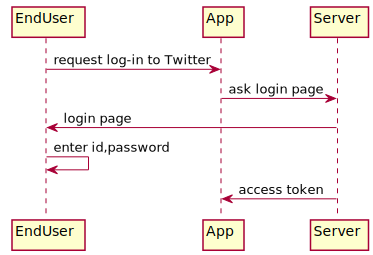

In [2]:
%%plantuml
@startuml
EndUser -> App: request log-in to Twitter
App -> Server: ask login page
Server -> EndUser : login page
EndUser -> EndUser : enter id,password
Server -> App: access token
@enduml

## 트위터 키 설정하기

* [트위터](https://twitter.com) 회원가입을 하고, 자신의 계정을 만든다.
* apps.twitter.com로 가서
* "Create New App" 앱을 생성한다.
* 앱의 이름, 설명을 입력
* 앱의 웹사이트를 입력 - 앱이 실행될 호스트. 없으면 임시로 넣는다. 또는 https://twitter.com

* "Keys and Access Tokens"를 누른다.
* "Create my access token"

* 2개의 키가 필요 - consumer, token

* 파일에 저장된 key를 사용한다.
    * java twitter4j에서 사용하는 twitter4j.properties 파일을 사용한다.
    * 첫 줄은 의미가 없으므로 버리고,
    * 나머지 줄은 '.' 뒤를 대문자로 바꾸어서 사용한다. line을 읽을 때 '\n'을 제거한다.

In [1]:
def getApiKey(keyPath):
    d=dict()
    f=open(keyPath,'r')
    for line in f.readlines():
        row=line.split('=')
        if(row[0]!='debug'):
            row0=row[0].split('.')
            d[row0[1].upper()]=row[1].strip()
    return d

In [3]:
import os

keyPath=os.path.join(os.path.expanduser("~"),'Code/git/bb/sd','twitter4j.properties')
key=getApiKey(keyPath)
#print key

## T-1: Twitter에 'Hello World'를 쓴다.

* 트위터 API문서 참조
    * statuses.update
    * https://dev.twitter.com/rest/reference/post/statuses/update
    * Parameters
        * 반드시 입력해야 하는 항목 ('required') -> status
    * 결과는 JSON
    * 주의: OAuth Signature가 있어야 함.

### Twitter 라이브러리 

In [4]:
import twitter
#auth = twitter.oauth.OAuth(ACCESS_TOKEN,ACCESS_TOKEN_SECRET,CONSUMER_KEY, CONSUMER_SECRET)
auth = twitter.oauth.OAuth(key['ACCESSTOKEN'],key['ACCESSTOKENSECRET'],
                            key['CONSUMERKEY'], key['CONSUMERSECRET'])
_client = twitter.Twitter(auth=auth)
print _client

In [43]:
_client.statuses.update(status="Hello Twitter 1 160924")

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Sat Sep 24 08:59:47 +0000 2016',
 u'entities': {u'hashtags': [],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': None,
 u'id': 779606243950211072,
 u'id_str': u'779606243950211072',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'no',
 u'place': None,
 u'retweet_count': 0,
 u'retweeted': False,
 u'source': u'<a href="http://jsl.com/" rel="nofollow">JSL</a>',
 u'text': u'Hello Twitter 2016-09-24 18:01',
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
  u'created_at': u'Sun Sep 19 00:44:43 +0000 2010',
  u'default_profile': True,
  u'default_profile_image': False,
  u'description': u'\uc0c1\uba85\ub300',
  u'entities': {u'description': {u'urls': []}},
  u'favourites_count': 1,
  u'fol

### OAuth2


In [3]:
import oauth2 as oauth
import json

#consumer = oauth.Consumer(key=CONSUMER_KEY, secret=CONSUMER_SECRET)
#token=oauth.Token(key=ACCESS_TOKEN, secret=ACCESS_TOKEN_SECRET)
consumer = oauth.Consumer(key=key['CONSUMERKEY'], secret=key['CONSUMERSECRET'])
token=oauth.Token(key=key['ACCESSTOKEN'], secret=key['ACCESSTOKENSECRET'])

In [4]:
client = oauth.Client(consumer, token)

In [7]:
help(client.request)

Help on method request in module oauth2:

request(self, uri, method='GET', body='', headers=None, redirections=5, connection_type=None) method of oauth2.Client instance



* POST
    * body param은 post에만 사용할 수 있다??
    * GET방식의 param은 url에 ?다음 붙여서 사용

In [7]:
import urllib
url = "https://api.twitter.com/1.1/statuses/update.json"
mybody=urllib.urlencode({'status': 'Hello 21 160924'})
response,content=client.request(url,method='POST',body=mybody)

In [74]:
print response

{'content-length': '1898', 'x-tsa-request-body-time': '0', 'x-xss-protection': '1; mode=block', 'x-content-type-options': 'nosniff', 'x-connection-hash': '2560f69bc98ebbb7a2454876de33b2ac', 'x-twitter-response-tags': 'BouncerCompliant', 'cache-control': 'no-cache, no-store, must-revalidate, pre-check=0, post-check=0', 'status': '200', 'content-disposition': 'attachment; filename=json.json', 'set-cookie': 'lang=en; Path=/, guest_id=v1%3A147470828205284327; Domain=.twitter.com; Path=/; Expires=Mon, 24-Sep-2018 09:11:22 UTC', 'expires': 'Tue, 31 Mar 1981 05:00:00 GMT', 'x-access-level': 'read-write', 'last-modified': 'Sat, 24 Sep 2016 09:11:22 GMT', '-content-encoding': 'gzip', 'pragma': 'no-cache', 'date': 'Sat, 24 Sep 2016 09:11:22 GMT', 'x-response-time': '186', 'x-transaction': '000f4a8300e57866', 'strict-transport-security': 'max-age=631138519', 'server': 'tsa_a', 'x-frame-options': 'SAMEORIGIN', 'content-type': 'application/json;charset=utf-8'}


In [75]:
print content

{"created_at":"Sat Sep 24 09:11:22 +0000 2016","id":779609156734947329,"id_str":"779609156734947329","text":"Hello 21 160924","truncated":false,"entities":{"hashtags":[],"symbols":[],"user_mentions":[],"urls":[]},"source":"\u003ca href=\"http:\/\/jsl.com\/\" rel=\"nofollow\"\u003eJSL\u003c\/a\u003e","in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":192388653,"id_str":"192388653","name":"Joasang Lim","screen_name":"jslimit","location":"","description":"\uc0c1\uba85\ub300","url":null,"entities":{"description":{"urls":[]}},"protected":false,"followers_count":11,"friends_count":2,"listed_count":0,"created_at":"Sun Sep 19 00:44:43 +0000 2010","favourites_count":1,"utc_offset":null,"time_zone":null,"geo_enabled":false,"verified":false,"statuses_count":30,"lang":"en","contributors_enabled":false,"is_translator":false,"is_translation_enabled":false,"profile_background_color":"C0DEE

* save
    * csv
    * json
* io모듈
    * Python 3을 대상으로 만들어진 모듈, python 2.에서는 file 대신

* twitter를 파일에 쓸 경우
    *  그냥 쓰면 quote 없이 - unicode문제???

In [11]:
f=open('src/ds_twitter_1_noquote.json','w')
f.write(content)
f.close()

In [16]:
import io
with io.open('src/ds_twitter_1.json', 'w', encoding='utf8') as json_file:
    data=json.dumps(content, json_file, ensure_ascii=False, encoding='utf8')
    json_file.write(data)

## T-2: 자신의 타임라인 가져오기

* 2개만 (count)
* 특정 시점 (max_id, since_id)
* 모두 가져오기


* GET statuses/home_timeline
    * 사용자와 그 친구들이 올리는 트윗과 리트윗을 가져옴
    * 800개 제한
    * 입력변수는 선택적
    * 출력은 JSON

```
user_timeline = client.statuses.user_timeline(screen_name='jslimit')
```

### Twitter  라이브러리

In [7]:
timeline = _client.statuses.home_timeline()

In [8]:
print type(timeline)
print len(timeline)

<class 'twitter.api.TwitterListResponse'>
20


* tweet은 키를 많이 가지고 있지만, 그 가운데 'id'에 대해 key, value를 출력한다.

In [13]:
for t in timeline:
    for key,val in t.items():
        if(key=='id'):
            print "key:%s ->\tvalue:%s" % (key,val)

key:id ->	value:797591133073223680
key:id ->	value:796255870912864256
key:id ->	value:779609156734947329
key:id ->	value:779607889086337024
key:id ->	value:779606243950211072
key:id ->	value:779604922371223552
key:id ->	value:768674417551347712
key:id ->	value:767873469119803392
key:id ->	value:767872599439343616
key:id ->	value:546932714822066176
key:id ->	value:534949539757555713
key:id ->	value:534945044000559104
key:id ->	value:534928555591745536
key:id ->	value:534924431919828992
key:id ->	value:534231478217867264
key:id ->	value:532410157867610112
key:id ->	value:532408731074437120
key:id ->	value:532408509577445377
key:id ->	value:532386310086881280
key:id ->	value:532331903043375104


In [24]:
print type(timeline[0])
for key in timeline[0].keys():
    print key,timeline[0][key]

<type 'dict'>
contributors None
truncated False
text Hello from oauth 2016-07-23 14:40
is_quote_status False
in_reply_to_status_id None
id 754188567824338944
favorite_count 0
source <a href="http://jsl.com/" rel="nofollow">JSL</a>
retweeted False
coordinates None
entities {u'symbols': [], u'user_mentions': [], u'hashtags': [], u'urls': []}
in_reply_to_screen_name None
in_reply_to_user_id None
retweet_count 0
id_str 754188567824338944
favorited False
user {u'follow_request_sent': False, u'has_extended_profile': False, u'profile_use_background_image': True, u'default_profile_image': False, u'id': 192388653, u'profile_background_image_url_https': u'https://abs.twimg.com/images/themes/theme1/bg.png', u'verified': False, u'profile_text_color': u'333333', u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/1218730885/___normal.jpg', u'profile_sidebar_fill_color': u'DDEEF6', u'entities': {u'description': {u'urls': []}}, u'followers_count': 11, u'profile_sidebar_border_color': u

### OAuth

* 2개만 가져오기
* 특정 시점
* 모두 가져오기
    * max_id, since_id

* mongo에 쓰기
    * _mclient를 생성해서
    * for문에 넣음

In [ ]:
from pymongo import MongoClient
_mclient = MongoClient()
_db=_mclient.ds_twitter


In [27]:
from pymongo import MongoClient
_mclient = MongoClient()
_db=_mclient.ds_twitter
_table=_db.home_timeline

In [28]:
url = "https://api.twitter.com/1.1/statuses/home_timeline.json"
response, content = client.request(url)

home_timeline = json.loads(content)
for tweet in home_timeline:
    _table.insert_one(tweet)
    print tweet['id'],tweet['text']

779609156734947329 Hello 21 160924
779607889086337024 Hello 2 160924
779606243950211072 Hello Twitter 2016-09-24 18:01
779604922371223552 Hello Twitter 2016-09-24 18:00
768674417551347712 Hello from oauth 2016-08-24 14:00
767873469119803392 Hello from oauth 2016-07-16 18:00
767872599439343616 Hello Twitter 2016-07-16 18:00
546932714822066176 parkmincheol
534949539757555713 hello 3:00 pm
534945044000559104 Hello from swing 2:40pm
534928555591745536 hello 1:40pm
534924431919828992 hello 13:21
534231478217867264 14:50pm
532410157867610112 14:50pm
532408731074437120 14:40pm
532408509577445377 14:30pm
532386310086881280 1:00pm
532331903043375104 Hello World jsl 2 939
532330981613502466 Hello World jsl 2
531712281260740609 hello from java2


* mongo에서 읽기

```from ds14_spark_ml.ipynb
_table=_db.seoul
cursor=_table.find()
for i,e in enumerate(cursor):
    if(i%100==0):
        print i,e['text']
        #parsedData = e['text'].map(lambda line: array([float(x) for x in line.split(' ')]))
```

In [36]:
for i in _db.home_timeline.find():
    print i

{u'contributors': None, u'truncated': False, u'text': u'Hello 21 160924', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 779609156734947329L, u'favorite_count': 0, u'source': u'<a href="http://jsl.com/" rel="nofollow">JSL</a>', u'retweeted': False, u'coordinates': None, u'entities': {u'symbols': [], u'user_mentions': [], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': None, u'id_str': u'779609156734947329', u'retweet_count': 0, u'in_reply_to_user_id': None, u'favorited': False, u'user': {u'follow_request_sent': False, u'has_extended_profile': False, u'profile_use_background_image': True, u'time_zone': None, u'id': 192388653, u'default_profile': True, u'verified': False, u'profile_text_color': u'333333', u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/1218730885/___normal.jpg', u'profile_sidebar_fill_color': u'DDEEF6', u'is_translator': False, u'geo_enabled': False, u'entities': {u'description': {u'urls': []}}, u'followers_count': 11, u'p

In [58]:
url = "https://api.twitter.com/1.1/statuses/home_timeline.json?count=2"
response, content = client.request(url)

home_timeline = json.loads(content)
for tweet in home_timeline:
    print tweet['id'],tweet['text']

768674417551347712 Hello from oauth 2016-08-24 14:00
767873469119803392 Hello from oauth 2016-07-16 18:00


In [22]:
print home_timeline[0]['created_at']
print home_timeline[0]['id']

Sat Jul 16 09:00:57 +0000 2016
754239388641406977


* pagination - 검색하거나, 타임라인을 읽어 오는 경우, 여러 번으로 나누어 가져온다.
    * 사용하는 변수
        * max_id = top of tweets id list
        * since_id = bottom of tweets id list
    * 언제 사용하나?
        * 사용사례1: 조회한 시점 이후 새로운 트윗이 추가되었을 경우
            * since_id는 조회한 시점
            * max_id는 새로 추가된 트윗까지
        * 사용사례2: 조회한 후, 그 다음 페이지를 읽어오는 경우 (오래된 것)
            * max_id만 사용
            * since_id는 불필요하므로 비워놓음
    * max_id부터 오래된 것을 읽어오기 -> 마지막 id는 어떻게 찾는가?
    * max 3200 (200개씩 16번 호출)

* 사용사례2

In [59]:
import urllib
url = "https://api.twitter.com/1.1/statuses/home_timeline.json"
myparam={'max_id':'532386310086881280'}
mybody=urllib.urlencode(myparam)

response, content = client.request(url+"?"+mybody, method="GET")
home_timeline = json.loads(content)
for tweet in home_timeline:
    print tweet['id'],tweet['text']

532386310086881280 1:00pm
532331903043375104 Hello World jsl 2 939
532330981613502466 Hello World jsl 2
531712281260740609 hello from java2
531549525509296129 Hello World jsl 2
531272491931410432 1130
531268424635146240 hello
531250812547125248 1003
530995513986793472 날이 흐린 날
212391733038817280 트윗 테슽
28702715408285697 This a simple test from twitter-async at 01-22-2011 03:41:48
28686704881704960 status update by POST from API console
28653235166257153 This a simple test from twitter-async at 01-22-2011 12:25:12
28652911965773824 This a simple test from twitter-async at 01-22-2011 12:23:55
28652284741156864 This a simple test from twitter-async at 01-22-2011 12:21:25
28454996737 RT @DirectorYoo: 이외수선생님 알티부탁드려요..@oisoo  b형백혈구헌혈이필요합니다 11살남자아이가 서울대병원 중환자실에 있습니다  b형성인남자는55키로이상여자는45키로이상 최근예방접종안하신분가능합니다010 9907 3780 연락 ...
18831928302 What a wonderful world !!!


In [60]:
import urllib
myparam={'max_id':'534949539757555713','since_id':'532386310086881280'}

mybody=urllib.urlencode(myparam)

response, content = client.request(url+"?"+mybody, method="GET")
home_timeline = json.loads(content)
for tweet in home_timeline:
    print tweet['id'],tweet['text']

534949539757555713 hello 3:00 pm
534945044000559104 Hello from swing 2:40pm
534928555591745536 hello 1:40pm
534924431919828992 hello 13:21
534231478217867264 14:50pm
532410157867610112 14:50pm
532408731074437120 14:40pm
532408509577445377 14:30pm


In [15]:
print home_timeline

[{u'contributors': None, u'truncated': False, u'text': u'1:00pm', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 532386310086881280, u'favorite_count': 0, u'source': u'<a href="http://jsl.com/" rel="nofollow">JSL</a>', u'retweeted': False, u'coordinates': None, u'entities': {u'symbols': [], u'user_mentions': [], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': None, u'in_reply_to_user_id': None, u'retweet_count': 0, u'id_str': u'532386310086881280', u'favorited': False, u'user': {u'follow_request_sent': False, u'has_extended_profile': False, u'profile_use_background_image': True, u'default_profile_image': False, u'id': 192388653, u'profile_background_image_url_https': u'https://abs.twimg.com/images/themes/theme1/bg.png', u'verified': False, u'profile_text_color': u'333333', u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/1218730885/___normal.jpg', u'profile_sidebar_fill_color': u'DDEEF6', u'entities': {u'description': {u'urls': []}}, u'fo

* 함수로 만들기

In [4]:
def oauth_req(url, http_method="GET", post_body='', http_headers=None):
    consumer = oauth.Consumer(key=CONSUMER_KEY, secret=CONSUMER_SECRET)
    token=oauth.Token(key=ACCESS_TOKEN, secret=ACCESS_TOKEN_SECRET)
    client = oauth.Client(consumer, token)
    response, content = client.request( url, method=http_method, body=post_body, headers=http_headers )
    return content
 
home_timeline = oauth_req('https://api.twitter.com/1.1/statuses/home_timeline.json')
home_timeline_json = json.loads(home_timeline)
for tweet in home_timeline_json:
    print tweet['text']

parkmincheol
hello 3:00 pm
Hello from swing 2:40pm
hello 1:40pm
hello 13:21
14:50pm
14:50pm
14:40pm
14:30pm
1:00pm
Hello World jsl 2 939
Hello World jsl 2
hello from java2
Hello World jsl 2
1130
hello
1003
날이 흐린 날
트윗 테슽
This a simple test from twitter-async at 01-22-2011 03:41:48


## T-3: Twitter에 'Seoul'을 10개 검색한다.

### Twitter


* 검색

In [14]:
q = '#류현진'
count = 100
# See https://dev.twitter.com/docs/api/1.1/get/search/tweets 
search_results = _client.search.tweets(q=q, count=count)
statuses = search_results['statuses']

In [66]:
print len(statuses)
print type(statuses)

100
<type 'list'>


In [15]:
print statuses[0].keys()

[u'contributors', u'truncated', u'text', u'is_quote_status', u'in_reply_to_status_id', u'id', u'favorite_count', u'entities', u'retweeted', u'coordinates', u'source', u'in_reply_to_screen_name', u'in_reply_to_user_id', u'retweet_count', u'id_str', u'favorited', u'user', u'geo', u'in_reply_to_user_id_str', u'possibly_sensitive', u'lang', u'created_at', u'in_reply_to_status_id_str', u'place', u'metadata']


In [16]:
for status in statuses[0:5]:
    print status['id'],status['text']

800967991642853376 #당일만남어플 #급벙개 비밀미팅 ▶ https://t.co/rJeQvLpgpX ◀
.
#송파금발 #군포여친구함 #성인사이트가입 #무료파일공유사이트 #홍대클럽여자 #야동스트리밍사이트 #밍키동영상 #류현진… https://t.co/8KhdCBEk4b
800930770017583105 #첫충20%, 매충5% #다리 #사설 #카톡 NBA070 #고총 #BJ #http://www.acc77.kr #트위터 #리니지 #파워볼 #피파 #사다리 #백아연 #살랑살랑 #지마켓 #토토 #위젯 #코드 toto #크레이지아케이드 #로하이 #류현진
800925674479304704 #만남앱 #목포벙개 쭉쭉빵빵 처녀만남 ▶ https://t.co/NngaxIm6Ne ◀
.
#제주남친구함 #류현진 #온라인채팅사이트 #키지마 #헌팅방법 #포커노하우 #부비부비 #스코어게임사다리사이트… https://t.co/Cyhf80xcTa
800892117677551616 #손예진 #MP3 #토토 #마우스 #CL #에일리 #추천게임 #야구픽 #편의점 #류현진 #스포츠 #좋은집구하기 #아이콘 #프로야구 #소셜커머스 #무사만루 #가희 #송재림 #탈렌트 #열린약국찾기 #거미 #신하균 #세이클럽 #가을야구 #플레임 #EBS
800847746424926208 #파워볼 #mnet #2군리그 #acc77.kr #러블리즈 #토토 #류현진 #이현우 #첫충20%, 매충5% #네임드 #가을야구 #고총 #사설 #게임키보드 #알람 #카톡 NBA070 #로하이 #다리 #코드 toto #패전투수 #사다리 #라이프스타일


### OAuth

* 'seoul'단어를 20개씩 검색

In [8]:
import urllib
url1 = "https://api.twitter.com/1.1/search/tweets.json"
myparam={'q':'seoul','count':20}
mybody=urllib.urlencode(myparam)

resp, tsearch = client.request(url1+"?"+mybody, method="GET")
tsearch_json = json.loads(tsearch)

In [9]:
print type(tsearch_json)
print tsearch_json.keys()
print len(tsearch_json['statuses'])

<type 'dict'>
[u'search_metadata', u'statuses']
20


In [10]:
len(tsearch_json['statuses'][0])

26

In [12]:
for i in range(1,5):
    print i

1
2
3
4


In [14]:
tsearch_json['statuses'][0]

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Mon Nov 14 03:41:09 +0000 2016',
 u'entities': {u'hashtags': [{u'indices': [84, 93], u'text': u'YoungJae'},
   {u'indices': [94, 101], u'text': u'GOT7\uc601\uc7ac'},
   {u'indices': [102, 105], u'text': u'\uc601\uc7ac'},
   {u'indices': [106, 110], u'text': u'\ucd5c\uc601\uc7ac'},
   {u'indices': [111, 115], u'text': u'\ud264\uc218\ub2ec'},
   {u'indices': [116, 121], u'text': u'GOT7'},
   {u'indices': [122, 126], u'text': u'\uac13\uc138\ube10'},
   {u'indices': [127, 137], u'text': u'ArirangTV'}],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': [{u'id': 66625290,
    u'id_str': u'66625290',
    u'indices': [3, 16],
    u'name': u'Arirang World',
    u'screen_name': u'arirangworld'},
   {u'id': 573299587,
    u'id_str': u'573299587',
    u'indices': [40, 53],
    u'name': u'GOT7',
    u'screen_name': u'GOT7Official'}]},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': None,
 u'id': 798007837053980672,
 u'id_str'

In [11]:
for i,tweet in enumerate(tsearch_json['statuses']):
    #print tweet[u'user'][u'name']
    print "[%d]\t%d\t%s:%s" % (i,tweet['id'],tweet['user']['name'],tweet['text'])

[0]	798007837053980672	Thiha:RT @arirangworld: &lt;Pops in Seoul&gt; @GOT7Official's Main Vocal &amp; Baby Otter #YoungJae #GOT7영재 #영재 #최영재 #퉤수달 #GOT7 #갓세븐 #ArirangTV https://t.c…
[1]	798007827256123392	어한이:RT @cuckicoco: Bye bye! Seoul! See u next time 👋🏻💕❤️ https://t.co/xnh0htfFtu
[2]	798007802291568640	🙏🏻💛:RT @yoosuparadise: 2016 XIA Ballad＆Musical Concert with Orchestra vol.5 - Dec 9 to 11th at Seoul Jamsil https://t.co/lIL2ZSpJAO ถ่ายบัตรหน้…
[3]	798007800886460417	Dreamimg KimSooHyun:❤❤❤161114 KimSooHyun  attend the Cuckoo Electronics Healthy Winter campaign event held at Lotte Hotel in Jung-gu, S… https://t.co/wXzaEfMA23
[4]	798007778531045376	#StayStrongTOPStans:News: Choi passed the test, will be on duty prob in Jan, might be seen in public around Seoul.
Me: *packs bag and buy tix to SK*
[5]	798007752907837440	~  졸귀 ~ 🐝:RT @bright_hong: 홍어 종북 처리하기 딱 좋은 날. 
@gelotin3 On Nov. 12 riot in Seoul, that peoples gathered abt 200.000 is all who admire DPRK ...외신은 "광…
[6]	79800774119740

##  T-3: Twitter에 'Seoul'을 2015년 12월 한 달 분량을 읽는다.

* 트윗을 pagination하려면:
    * max_id (맨 위), since_id (맨 뒤)를 사용한다.
    * 트윗의 id는 정확하지 않거나, 존재하지 않아도 된다.
* 특정한 시간대의 트윗 검색하기
    * 트위터에서 tweet id를 알아내기
        * 단계1: 트위터에 로그인해서 타임라인을 조회
        * 단계2: 시간을 누른다.
        * 단계3: 브라우저 주소창 끝에 id가 붙어 있다.
    * 찾고자 하는 시간대에 해당하는 트윗을 찾아서 tweet id를 찾는다.
        * July 1 2016 아침 6시쯤 id는 748862169026928640
        * jslmit계정의 메시지 'hello 3:00 pm' -> 10:01 PM - 18 Nov 2014 -> 534949539757555713  -> 'max_id' 이것으로 검색하면 결과가 없슴 (empty list)
        * jslmit계정의 메시지 '1:00 pm' -> 8:16 PM - 11 Nov 2014 532386310086881280  -> 'since_id'

* 한글만 읽어오려면 'lang'을 한국어로 검색조건에 넣어준다.


### interactive session

* 묶어서 저장하면 일괄 실행 할 수 있다 (아래 all-in-one).
* [nok max_id 20161124]
    * max_id를 특정id로 정하면 작동되지 않음. _max_id를 최근 것으로 하면 ok
    * since_id는 ok


In [20]:
import urllib
url = "https://api.twitter.com/1.1/search/tweets.json"
myparam={'q':'seoul','count':200,'since_id':'534949539757555713'}
#myparam={'q':'seoul','count':200,'max_id':'534949539757555713'}
mybody=urllib.urlencode(myparam)
response, content = client.request(url+"?"+mybody, method="GET")
tsearch_json = json.loads(content)

In [21]:
print len(tsearch_json)
print len(tsearch_json['statuses'])

2
100


In [19]:
print tsearch_json['statuses'][-1]['id']

801644923774595072


In [24]:
f=open('data/ds_tweet_3a.txt','w')
for i,tweet in enumerate(tsearch_json['statuses']):
    #print str(i),tweet['id'],tweet['user']['name'],tweet['text']
    #f.write(json.dumps([str(i),tweet['id'],tweet['user']['name'],tweet['text']]))
    f.write(json.dumps([str(i),tweet['id'],tweet['user']['name']]))
    f.write("\n")
    #print _t
    #f.write(_t)
f.close()

* Rate limit까지 읽음
    * prev_id는 전 id를 저장
    * 
* todo
    * rate limit handling?? 알고리즘?
    * statuses = [] 읽어온 데이터가 없는 경우


In [ ]:
import urllib
url = "https://api.twitter.com/1.1/search/tweets.json"

In [25]:
prev_id=None
f=open('data/ds_tweet_3b.txt','a')
for i in range(0,2):
    myparam={'q':'seoul','count':10,'max_id':prev_id}
    mybody=urllib.urlencode(myparam)
    response, content = client.request(url+"?"+mybody, method="GET")
    tsearch_json = json.loads(content)
    print len(tsearch_json['statuses'])
    for i,tweet in enumerate(tsearch_json['statuses']):
        #print str(i),tweet['id'],tweet['user']['name'],tweet['text']
        f.write(json.dumps([str(i),tweet['id'],tweet['user']['name']]))
        f.write("\n")
    #if data["statuses"] == []:
    #    print "end of data"
    #    break
    #else:
    prev_id=int(tsearch_json['statuses'][-1]['id'])-1
    print prev_id
f.close()

10
801647434514382847
10
801647288011472895


### all-in-one python

* 재사용
    * getApiKey()함수.
    * oauth client.
    * mongo 저장.
    * 위에 작성한 프로그램.

* 쓰기

구분 | 파일명
-----|-----
json (append) | src/ds_twitter_seoul_3.json
text file (append) | src/ds_twitter_seoul_3.txt
mongo (같은 레코드 중복함) | ds_twitter.seoul

In [7]:
%%writefile src/ds_twitter_3.py
import urllib
import os
import oauth2 as oauth
import json

def getApiKey(keyPath):
    d=dict()
    f=open(keyPath,'r')
    for line in f.readlines():
        row=line.split('=')
        if(row[0]!='debug'):
            row0=row[0].split('.')
            d[row0[1].upper()]=row[1].strip()
    return d

# 1. key
keyPath=os.path.join(os.path.expanduser("~"),'Code/git/sd','twitter4j.properties')
key=getApiKey(keyPath)
# 2. oauth client
consumer = oauth.Consumer(key=key['CONSUMERKEY'], secret=key['CONSUMERSECRET'])
token=oauth.Token(key=key['ACCESSTOKEN'], secret=key['ACCESSTOKENSECRET'])
client = oauth.Client(consumer, token)

# 3. pymongo
from pymongo import MongoClient
Client = MongoClient('localhost:27017')
_db=Client.ds_twitter
_collection=_db.seoul
def saveDB(_data):
    _collection.insert(_data)

def readDB():
    for tweet in _collection.find():
        print tweet['id'],tweet['text']

# 4. file: NOTE to cast into string
_fname='src/ds_twitter_seoul_3.txt'
def saveFile(_fname,_data):
    fp=open(_fname,'a')
    fp.write(str(_data))
    #fp.write(_data+"\n")

# 5. json
_jfname='src/ds_twitter_seoul_3.json'
def saveJson(_fname,_data):
    import io
    with io.open(_fname, 'a', encoding='utf8') as json_file:
        _j=json.dumps(_data, json_file, ensure_ascii=False, encoding='utf8')
        json_file.write(_j+"\n")
def readJson(_fname):
    for line in open(_fname, 'r').readlines():
        _j=json.loads(line)
        #print _j['id'],_j['text']
        print _j['id']

# 6. twitter search
url = "https://api.twitter.com/1.1/search/tweets.json"
_ids=list()
_max_id=None
#_since_id=None
_count=200
_maxIter=20
_iter=0
while _iter<_maxIter:
    myparam={'q':'seoul','count':_count,'max_id':_max_id}
    #myparam={'q':'seoul','count':_count,'since_id':_since_id}
    mybody=urllib.urlencode(myparam)
    response, content = client.request(url+"?"+mybody, method="GET")
    tsearch_json = json.loads(content)
    print len(tsearch_json)
    for i,tweet in enumerate(tsearch_json['statuses']):
            #print tweet['id'],tweet['text']
            if(i%10==0):
                print i,tweet['id']
            saveJson(_jfname,tweet) # with quotes, this does not work!!
            saveFile(_fname,tweet)
            saveDB(tweet)
    _max_id=tweet['id']
    #_since_id=tweet['id']
    _ids.append(tweet['id'])
    _iter+=1

#print "-----reading back"
#readJson(_jfname)
#readDB()
print _ids

Overwriting src/ds_twitter_3.py


In [9]:
!python src/ds_twitter_3.py

2
0 801955891956236288
10 801955750666899456
20 801955663400341505
30 801955555627573248
40 801955413780361216
50 801955207877894144
60 801955090516963328
70 801954991598665732
80 801954800430551041
90 801954594511142912
2
0 801954514265702400
10 801954390798020608
20 801954222598197248
30 801954098924769280
40 801953896318910464
50 801953736495079424
60 801953609734758401
70 801953513672540160
80 801953406390857728
90 801953312496959489
2
0 801953207262003202
10 801953033651298304
20 801952930085490688
30 801952828285562880
40 801952761436925952
50 801952678112686080
60 801952597301084161
70 801952469966127104
80 801952372515741696
90 801952255314313220
2
0 801952181213655040
10 801952083746451457
20 801951858432606208
30 801951741100949504
40 801951674126340096
50 801951528990883840
60 801951371427741696
70 801951303878356992
80 801951161188118528
90 801951015662587904
2
0 801950903603380224
10 801950818911952896
20 801950718420623360
30 801950641358663680
40 801950576569249792
50 80

## T-5: Follower를 가져온다.

In [17]:
import urllib
url = "https://api.twitter.com/1.1/followers/list.json"
#myparam={'q':'seoul','count':20,'max_id':'754295227351871489'}
#mybody=urllib.urlencode(myparam)
response, content = client.request(url, method="GET")
tfollower_json = json.loads(content)

In [18]:
print len(tfollower_json)
print type(tfollower_json)


5
<type 'dict'>


In [143]:
for k,v in tfollower_json.iteritems():
    print k

previous_cursor
previous_cursor_str
next_cursor
users
next_cursor_str


In [150]:
for k,v in tfollower_json['users'][0].iteritems():
        print k

follow_request_sent
has_extended_profile
profile_use_background_image
default_profile_image
id
profile_background_image_url_https
verified
blocked_by
profile_text_color
muting
profile_image_url_https
profile_sidebar_fill_color
entities
followers_count
profile_sidebar_border_color
id_str
profile_background_color
listed_count
status
is_translation_enabled
utc_offset
statuses_count
description
friends_count
location
profile_link_color
profile_image_url
following
geo_enabled
blocking
profile_background_image_url
screen_name
lang
profile_background_tile
favourites_count
name
notifications
url
created_at
contributors_enabled
time_zone
protected
default_profile
is_translator


In [19]:
for i in tfollower_json['users']:
    print i['id'],i['screen_name']

151797293 mycarten
3011800740 amyhuh65
157562595 Luxemburx
343218787 75375652
1645118360 jjhcp
986237041 DracoSwida
168089220 hchae00
118962348 htmzzz
71177815 sbjin1229
88356600 serenoheka
192388167 iKKaia8p8


## T-6: Follower의 timeline을 가져온다.

### Twitter 라이브러리

In [ ]:
print _client.follwers()

### OAuth

* 위에서 수동으로 첫번쨰 followerd의 user_timeline

In [152]:
import urllib
url = "https://api.twitter.com/1.1/statuses/user_timeline.json"
#myparam={'q':'seoul','count':20,'max_id':'754295227351871489'}
#mybody=urllib.urlencode(myparam)
response, content = client.request(url+"?"+'user_id=151797293', method="GET")
tuser_timeline_json = json.loads(content)

In [153]:
print len(tuser_timeline_json)
print type(tuser_timeline_json)


20
<type 'list'>


In [160]:
for i in tuser_timeline_json:
    print i['id'],i['text']

 753507089868214272 전문가기고 ( 전자신문 7월4일 칼럼) 친환경차로 가는 길목의 대안은 가스차    https://t.co/PNsids1Xkx
753506984398204929 자동차10년타기운동본부가 추천하는 부천, 인천, 대구 착한정비센터를 소개합니다. 오래된 승용차는 너무 좋습니다. https://t.co/c8XmCDLQj5
753506761026342913 자동차10년타기운동본부가 추천하는 서울 , 경기 착한정비센터   https://t.co/EMfPHfAtWM
753506668822958080 자동차10년타기운동본부가 추천하는 부천, 인천, 대구 착한정비센터를 소개합니다   https://t.co/c8XmCDLQj5
753506592390119425 자동차10년타기운동본부가 추천하는 대구 , 부산 착한정비센터를 소개합니다   https://t.co/3YHQvwoe9Z
753506505635139586 자동차10년타기운동본부가 추천하는 부산 , 호남, 충청, 대전 착한정비센터를 소개합니다   https://t.co/dI5k6CGSIm
752628644716027904 자동차10년타기운동본부가 추천하는 서울 , 경기 착한정비센터   https://t.co/EMfPHfAtWM
752628519880957956 자동차10년타기운동본부가 추천하는 부천, 인천, 대구 착한정비센터를 소개합니다   https://t.co/c8XmCDLQj5
752628350368124929 자동차10년타기운동본부가 추천하는 대구 , 부산 착한정비센터를 소개합니다   https://t.co/3YHQvwoe9Z
752628036772605952 자동차10년타기운동본부가 추천하는 부산 , 호남, 충청, 대전 착한정비센터를 소개합니다   https://t.co/dI5k6CGSIm
752616479284142081 동영상을 @YouTube 재생목록 https://t.co/UoOSHI3gsm 아이언 샷을 할 때 리듬이 급해지고 볼을 향해 덤벼드는
752616257921376

## T- : Twitter 트렌드 읽기


In [ ]:
### Twitter

In [38]:
WORLD_WOE_ID = 1
US_WOE_ID = 23424977
# Prefix ID with the underscore for query string parameterization.
# Without the underscore, the twitter package appends the ID value
# to the URL itself as a special case keyword argument.
world_trends = _client.trends.place(_id=WORLD_WOE_ID)
us_trends = _client.trends.place(_id=US_WOE_ID)

In [39]:
print world_trends.count
print us_trends.pop()

<built-in method count of TwitterListResponse object at 0x7f0791706890>
{u'created_at': u'2016-07-16T05:53:00Z', u'trends': [{u'url': u'http://twitter.com/search?q=%232016in3words', u'query': u'%232016in3words', u'tweet_volume': 70031, u'name': u'#2016in3words', u'promoted_content': None}, {u'url': u'http://twitter.com/search?q=%23ThingsTrumpWillNeverHave', u'query': u'%23ThingsTrumpWillNeverHave', u'tweet_volume': 45514, u'name': u'#ThingsTrumpWillNeverHave', u'promoted_content': None}, {u'url': u'http://twitter.com/search?q=%23HappyBirthdayLuke', u'query': u'%23HappyBirthdayLuke', u'tweet_volume': 123118, u'name': u'#HappyBirthdayLuke', u'promoted_content': None}, {u'url': u'http://twitter.com/search?q=%23InsteadOfSleepLets', u'query': u'%23InsteadOfSleepLets', u'tweet_volume': None, u'name': u'#InsteadOfSleepLets', u'promoted_content': None}, {u'url': u'http://twitter.com/search?q=%23WeMissZouis', u'query': u'%23WeMissZouis', u'tweet_volume': 51431, u'name': u'#WeMissZouis', u'promo

## Request token

In [13]:
import json
# Request token URL for Twitter.
request_token_url = "https://api.twitter.com/oauth/request_token"

# Create our client.
client = oauth.Client(consumer)

# The OAuth Client request works just like httplib2 for the most part.
resp, content = client.request(request_token_url, "GET")
print json.dumps(resp, indent=4)
print json.dumps(content, indent=4)

{
    "content-length": "121", 
    "x-xss-protection": "1; mode=block", 
    "x-content-type-options": "nosniff", 
    "x-connection-hash": "52b2074b1714b596fffe3d7d3b852fa1", 
    "x-twitter-response-tags": "BouncerCompliant", 
    "x-ua-compatible": "IE=edge,chrome=1", 
    "cache-control": "no-cache, no-store, must-revalidate, pre-check=0, post-check=0", 
    "status": "200", 
    "set-cookie": "guest_id=v1%3A145343501151492798; Domain=.twitter.com; Path=/; Expires=Sun, 21-Jan-2018 03:56:51 UTC", 
    "expires": "Tue, 31 Mar 1981 05:00:00 GMT", 
    "last-modified": "Fri, 22 Jan 2016 03:56:51 GMT", 
    "-content-encoding": "gzip", 
    "pragma": "no-cache", 
    "date": "Fri, 22 Jan 2016 03:56:51 GMT", 
    "content-location": "https://api.twitter.com/oauth/request_token?oauth_body_hash=2jmj7l5rSw0yVb%2FvlWAYkK%2FYBwk%3D&oauth_nonce=37280500&oauth_timestamp=1453435010&oauth_consumer_key=YU0ELwoiXP90d1I8VZikiA&oauth_signature_method=HMAC-SHA1&oauth_version=1.0&oauth_signature=qL5EB

### Signing a Request

* 요청을 사인
Twitter currently encrypts using a 160-bit (SHA-1) hash-based message authentication
code (HMAC), which we specify in the signature method. The print headers statement
will print the authorization header to the console.

In [161]:
# Set the base oauth_* parameters along with any other parameters required
# for the API call.
import time
params = {
    "oauth_version": "1.0",
    "oauth_nonce": oauth.generate_nonce(),
    "oauth_timestamp": int(time.time())
}

# Set our token/key parameters
params['oauth_token'] = token.key
params['oauth_consumer_key'] = consumer.key
# set the API endpoint
url1 = "https://api.twitter.com/1.1/search/tweets.json"

url = url1
req = oauth.Request(method="GET", url=url, parameters=params)
signature_method = oauth.SignatureMethod_HMAC_SHA1()
req.sign_request(signature_method, consumer, token)
headers = req.to_header()
url = req.to_url()
print headers
print url

{'Authorization': u'OAuth realm="", oauth_body_hash="2jmj7l5rSw0yVb%2FvlWAYkK%2FYBwk%3D", oauth_nonce="50817605", oauth_timestamp="1468681667", oauth_consumer_key="YU0ELwoiXP90d1I8VZikiA", oauth_signature_method="HMAC-SHA1", oauth_version="1.0", oauth_token="192388653-TDVYxBdEVqxjHIP90g11W3PoxZWPpvwgyEKnTMRu", oauth_signature="FYl7qWM2pQYjkBQ5%2FJgf0RBx%2FZA%3D"'}
https://api.twitter.com/1.1/search/tweets.json?oauth_body_hash=2jmj7l5rSw0yVb%2FvlWAYkK%2FYBwk%3D&oauth_nonce=50817605&oauth_timestamp=1468681667&oauth_consumer_key=YU0ELwoiXP90d1I8VZikiA&oauth_signature_method=HMAC-SHA1&oauth_version=1.0&oauth_token=192388653-TDVYxBdEVqxjHIP90g11W3PoxZWPpvwgyEKnTMRu&oauth_signature=FYl7qWM2pQYjkBQ5%2FJgf0RBx%2FZA%3D


## search twitter

* https://dev.twitter.com/rest/reference/get/search/tweets
* GET search/tweets
* Resource URL https://api.twitter.com/1.1/search/tweets.json


In [162]:
import urllib2
url = url1
params["q"] = "seoul"
params["count"] = 20
req = oauth.Request(method="GET", url=url, parameters=params)
signature_method = oauth.SignatureMethod_HMAC_SHA1()
req.sign_request(signature_method, consumer, token)
headers = req.to_header()
url = req.to_url()
response = urllib2.Request(url)
data = json.load(urllib2.urlopen(response))
#print data['statuses']
#print type(data)

print data['statuses'][0]['text']
print data['statuses'][0]['id']

for i,item in enumerate(data['statuses']):
    print "/%d/ %s" % (i, item['text'])

@liizziiiiieeee btw i'm suddenly watching nct life in seoul haha huhu
754331720015417349
/0/ @liizziiiiieeee btw i'm suddenly watching nct life in seoul haha huhu
/1/ RT @Charlie1601: รีวิวขนม Skinfood cafe ที่คาโรซูกิล และอื่นๆอีกมากมาย ฝากด้วยงับ
https://t.co/FCQv7Dka04 @seoulstorys @Seoul_Cafe https://…
/2/ RT @_HelloJaehyun: คือตอน nct life in seoul เห็นแทยงสดใสแบบนั้นใครจะคิดล่ะว่าหลังกล้องแทยงจะร้องไห้อ่ะ 😭 *จับกอด* https://t.co/kKxKIVCwwS
/3/ @nocturnal_seoul @Reyshiyel @pinksiren18 Showing pa ba pagpunta namin? If yes, taraaa! 😆
/4/ RT @NCT_TH: 160716 Fanboard #NCTU #NCT 
แฟน : TEN! TEN! U R THE LUV!♡ TEN THE LUV♡
เตนล์ : thank you for the support !!!  (ต่อ) https://t.c…
/5/ RT @_HelloJaehyun: คือตอน nct life in seoul เห็นแทยงสดใสแบบนั้นใครจะคิดล่ะว่าหลังกล้องแทยงจะร้องไห้อ่ะ 😭 *จับกอด* https://t.co/kKxKIVCwwS
/6/ RT @Charlie1601: รีวิวขนม Skinfood cafe ที่คาโรซูกิล และอื่นๆอีกมากมาย ฝากด้วยงับ
https://t.co/FCQv7Dka04 @seoulstorys @Seoul_Cafe https://…
/7/ RT @parkult: it's so 

## T-9: WordCloud

* font path
/etc/fonts/fonts.conf
vim /etc/fonts/conf.d/README
* 파일에서 읽어올 수 있다.

https://github.com/amueller/word_cloud

sudo pip install wordcloud

conda install -c https://conda.anaconda.org/amueller wordcloud

In [19]:
from os import path
from wordcloud import WordCloud

#d = path.dirname(__file__)

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()

text="Hello this is a sample"
#text=u"안녕하세요 this 샘플"
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

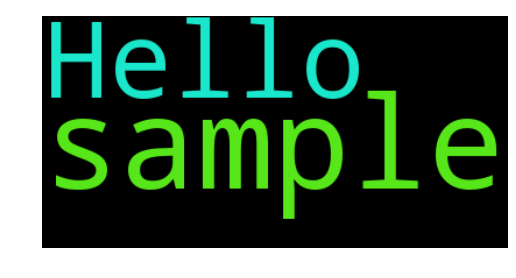

In [20]:
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

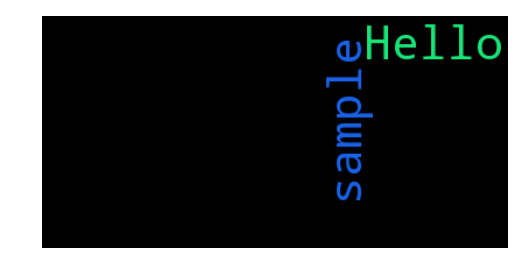

In [21]:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 더해보기

### Facebook

* Graph API
    * Access Token을 받아서, api를 테스트할 수 있는 사이트
    * https://developers.facebook.com/tools/explorer/ 


In [1]:
ACCESS_TOKEN="145728022146900|9QR40z4vC0rWcrEr2Pye8N8F-cQ"

In [2]:
import requests
import json

base_url = 'https://graph.facebook.com/me'

# Get 10 likes for 10 friends
fields = 'id,name,friends.limit(10).fields(likes.limit(10))'

url = '%s?fields=%s&access_token=%s' % \
    (base_url, fields, ACCESS_TOKEN,)

content = requests.get(url).json()
print content

{u'error': {u'message': u'An active access token must be used to query information about the current user.', u'code': 2500, u'type': u'OAuthException', u'fbtrace_id': u'HT2IV4CYP9j'}}


* Post
    * http://nodotcom.org/python-facebook-tutorial.html

## Meetup


In [4]:
# %load _meetup.py
# ref: https://rosettacode.org/wiki/Using_the_Meetup.com_API
import requests
import json

params={'city':'seoul','key':'383b2f3a196157f3d40195b5e2a6b73','topic':'photo'}
url_path='https://api.meetup.com'+'/2/open_events'
r=requests.get(url_path,params=params)
print r.text[:1000]



{"results":[{"utc_offset":-36000000,"venue":{"country":"US","localized_country_name":"USA","city":"Honolulu","address_1":"1138 Fort Street Mall","name":"Rain Restaurant ","lon":-157.86047,"id":25127447,"lat":21.31039,"repinned":false},"rsvp_limit":5,"headcount":0,"visibility":"public","waitlist_count":0,"created":1490287987000,"maybe_rsvp_count":0,"description":"<p>This will be my 1st time trying it, but great reviews on it<\/p> <p>Rain is downtown’s new destination for style and sustenance. Boasting an inspired shared-plate menu and nationally recognized drink program, the restaurant features classic American fare, refined by global flavors and served small-plate style. Rain delivers a meticulously curated boutique bistro menu.<\/p> <p>Rain’s robust drink program offers signature martinis, hand-crafted from house-made cellos. Unique cocktails are highlighted with custom-made ice, and copper mugs with ginger beer are created with premium specialty liquors.<\/p> <p>A dynamic dining expe